In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# 追加のモデルをインポート
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

/kaggle/input/test.csv
/kaggle/input/train.csv


In [74]:
train_df = pd.read_csv("../input/train.csv", skipinitialspace=True)
test_df = pd.read_csv("../input/test.csv", skipinitialspace=True)
master = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

# 文字列列を一括でstripし、空白のみをNaNに
str_cols = master.select_dtypes(include=["object"]).columns
master[str_cols] = (master[str_cols]
                .apply(lambda s: s.str.strip())
                .replace(r"^\s*$", np.nan, regex=True))

# Kaggle互換の Survived が欲しい場合（Perished があるときだけ）
if "Perished" in train_df.columns and "Survived" not in train_df.columns:
    train_df["Survived"] = 1 - train_df["Perished"]

In [75]:
train_df.describe()


,PassengerId,Perished,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.616162,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,1.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Perished     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Survived     891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


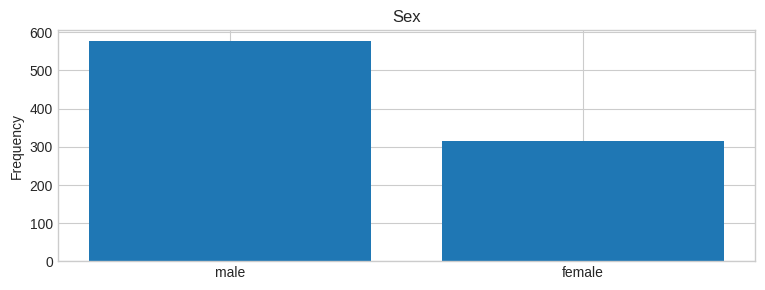

Sex: 
 Sex
male      577
female    314
Name: count, dtype: int64


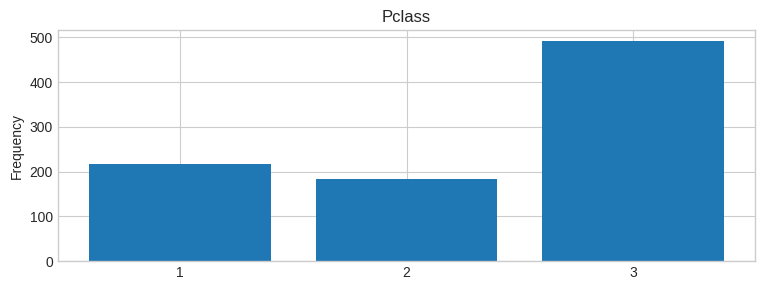

Pclass: 
 Pclass
3    491
1    216
2    184
Name: count, dtype: int64


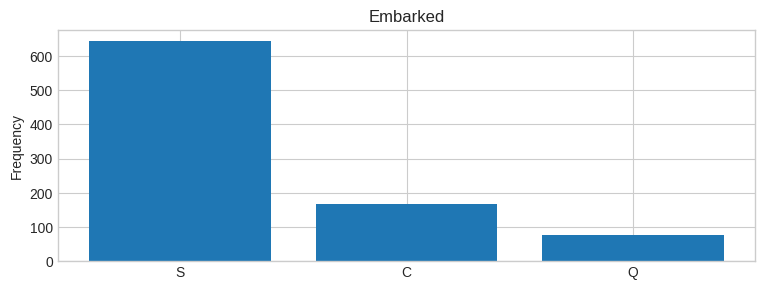

Embarked: 
 Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


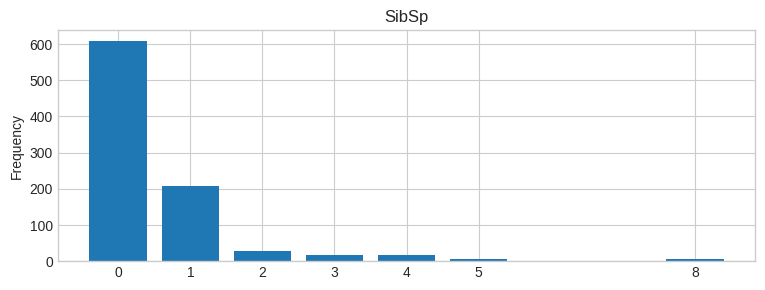

SibSp: 
 SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64


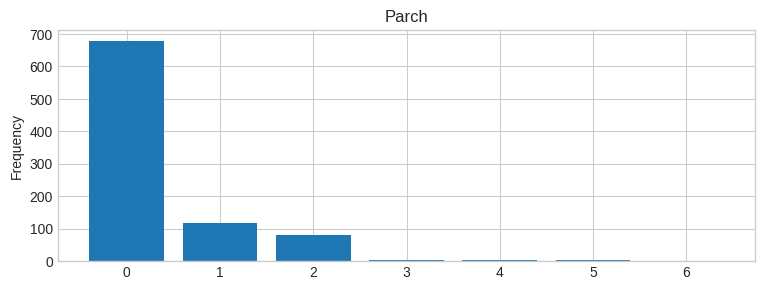

Parch: 
 Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64


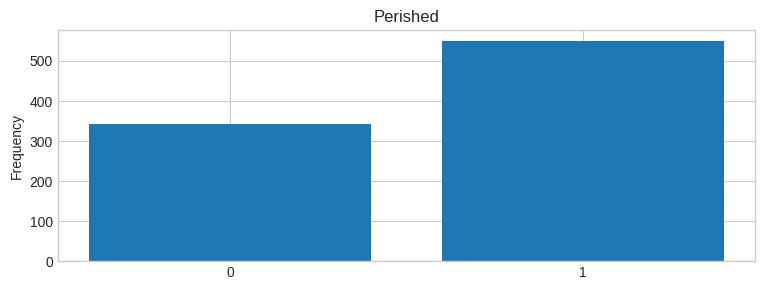

Perished: 
 Perished
1    549
0    342
Name: count, dtype: int64


In [77]:
def bar_plot(variable):
    """
        input: variable ex: "Sex"
        output: bar plot & value count
    """
    # get feature
    var = train_df[variable]
    # count number of categorical variable(value/sample)
    varValue = var.value_counts()
    
    # visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("Frequency")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))
    
category1 = ["Sex","Pclass","Embarked","SibSp", "Parch", "Perished"]
for c in category1:
    bar_plot(c)


In [78]:
category2 = ["Cabin", "Name", "Ticket"]
for c in category2:
    print("{} \n".format(train_df[c].value_counts()))

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64 

Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64 

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64 



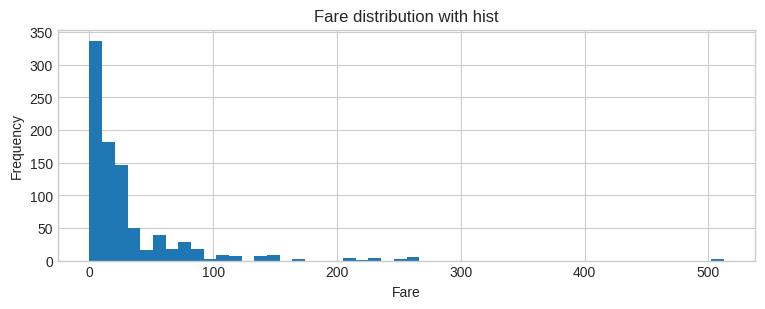

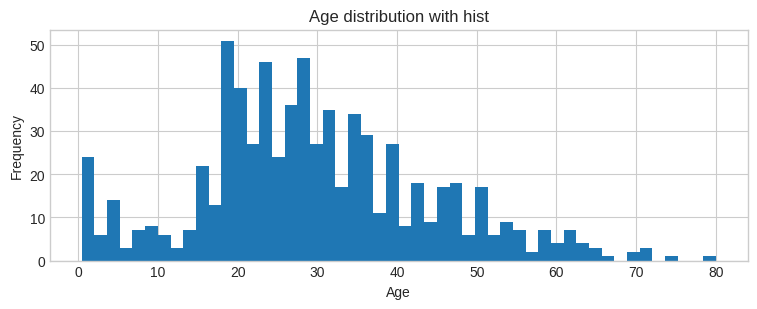

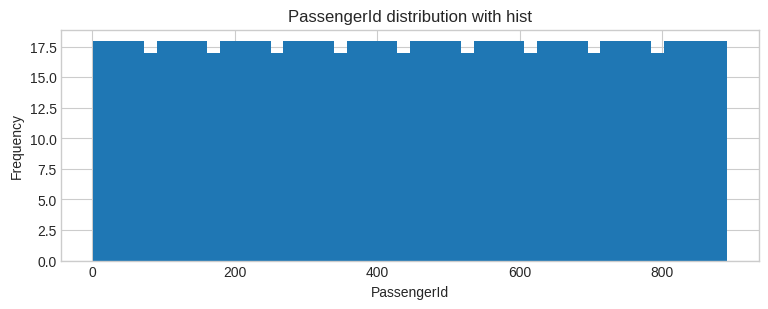

In [79]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(train_df[variable], bins = 50)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()
numericVar = ["Fare", "Age","PassengerId"]
for n in numericVar:
    plot_hist(n)

In [80]:
# Plcass vs Survived
train_df[["Pclass","Perished"]].groupby(["Pclass"], as_index = False).mean().sort_values(by="Perished",ascending = False)

,Pclass,Perished
2,3,0.757637
1,2,0.527174
0,1,0.370370


In [81]:
# Sex vs Survived
train_df[["Sex","Perished"]].groupby(["Sex"], as_index = False).mean().sort_values(by="Perished",ascending = False)

,Sex,Perished
1,male,0.811092
0,female,0.257962


In [82]:
# Sibsp vs Survived
train_df[["SibSp","Perished"]].groupby(["SibSp"], as_index = False).mean().sort_values(by="Perished",ascending = False)

,SibSp,Perished
5,5,1.000000
6,8,1.000000
4,4,0.833333
3,3,0.750000
0,0,0.654605
2,2,0.535714
1,1,0.464115


In [83]:
# Parch vs Survived
train_df[["Parch","Perished"]].groupby(["Parch"], as_index = False).mean().sort_values(by="Perished",ascending = False)

,Parch,Perished
4,4,1.000000
6,6,1.000000
5,5,0.800000
0,0,0.656342
2,2,0.500000
1,1,0.449153
3,3,0.400000


In [84]:
def detect_outliers(df,features):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)
    
    return multiple_outliers
train_df.loc[detect_outliers(train_df,["Age","SibSp","Parch","Fare"])]


,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
27,28,1,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S,0
88,89,0,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S,1
159,160,1,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
180,181,1,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
201,202,1,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
324,325,1,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
341,342,0,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S,1
792,793,1,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S,0
846,847,1,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S,0
863,864,1,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,0


In [85]:
# drop outliers
train_df = train_df.drop(detect_outliers(train_df,["Age","SibSp","Parch","Fare"]),axis = 0).reset_index(drop = True)

In [86]:
train_df_len = len(train_df)
train_df = pd.concat([train_df,test_df],axis = 0).reset_index(drop = True)
train_df.head()

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,1.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,0.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1.0
2,3,0.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,0.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1.0
4,5,1.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.0


In [87]:
train_df.columns[train_df.isnull().any()]

Index(['Perished', 'Age', 'Fare', 'Cabin', 'Embarked', 'Survived'], dtype='object')

In [88]:
train_df.isnull().sum()

PassengerId       0
Perished        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
Survived        418
dtype: int64

In [89]:
train_df[train_df["Embarked"].isnull()]

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
60,62,0.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1.0
821,830,0.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1.0


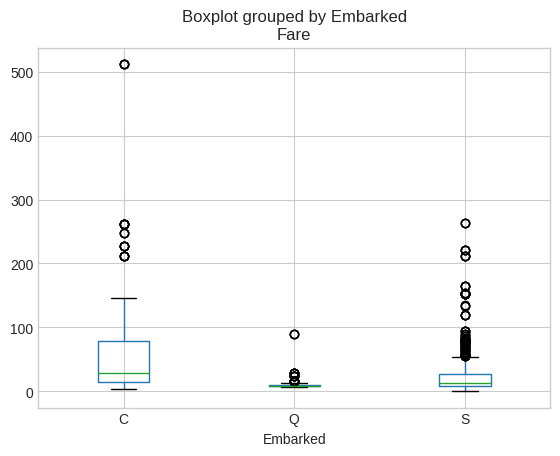

In [90]:
train_df.boxplot(column="Fare",by = "Embarked")
plt.show()

In [91]:
train_df["Embarked"] = train_df["Embarked"].fillna("C")
train_df[train_df["Embarked"].isnull()]

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived


In [92]:
train_df[train_df["Fare"].isnull()]

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
1033,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,NaN


In [93]:
train_df["Fare"] = train_df["Fare"].fillna(np.mean(train_df[train_df["Pclass"] == 3]["Fare"]))
train_df[train_df["Fare"].isnull()]

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived


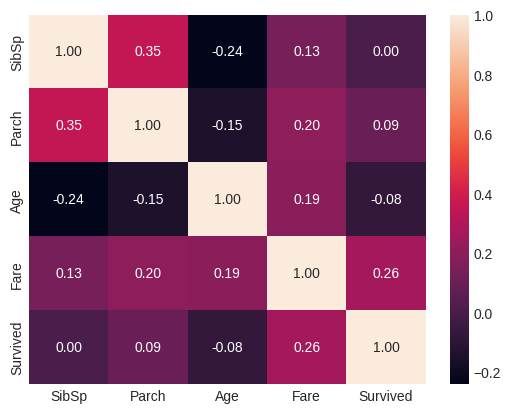

In [94]:
list1 = ["SibSp", "Parch", "Age", "Fare", "Survived"]
sns.heatmap(train_df[list1].corr(), annot = True, fmt = ".2f")
plt.show()

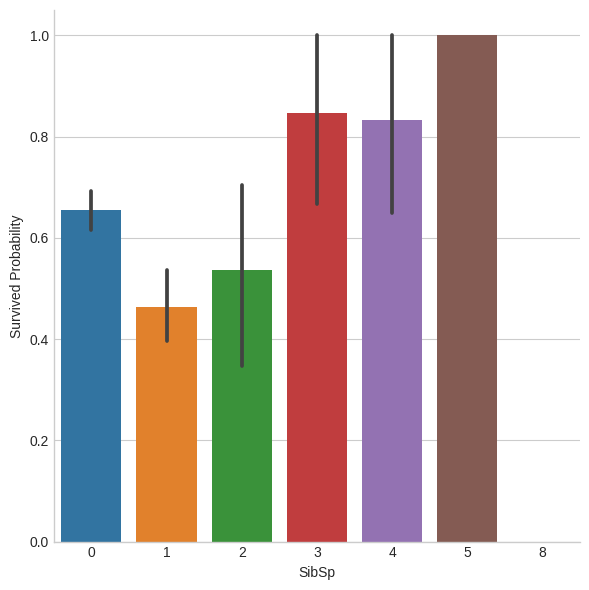

In [95]:
g = sns.catplot(x = "SibSp", y = "Perished", data = train_df, kind = "bar", height = 6)
g.set_ylabels("Survived Probability")
plt.show()

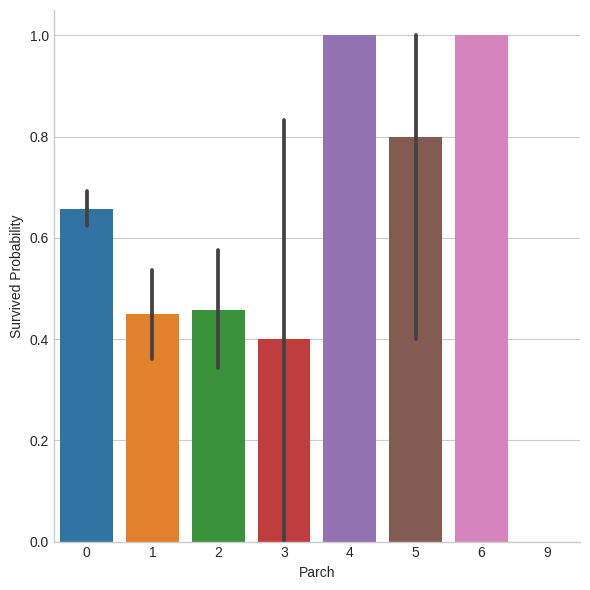

In [96]:
g = sns.catplot(x = "Parch", y = "Perished", kind = "bar", data = train_df, height = 6)
g.set_ylabels("Survived Probability")
plt.show()


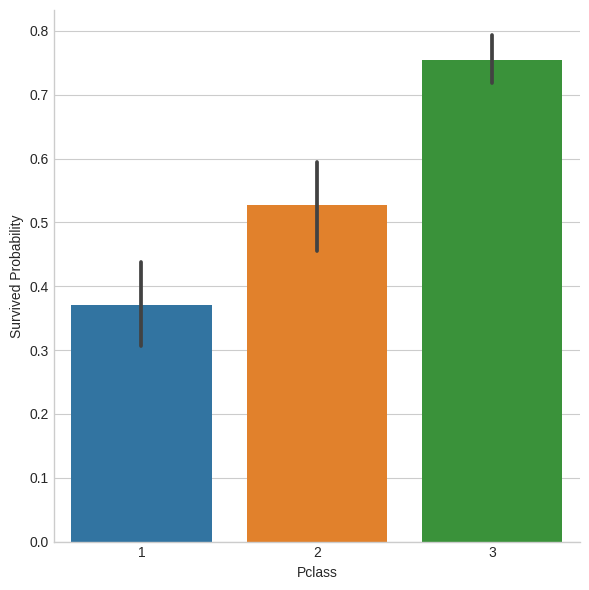

In [97]:
g = sns.catplot(x = "Pclass", y = "Perished", data = train_df, kind = "bar", height = 6)
g.set_ylabels("Survived Probability")
plt.show()

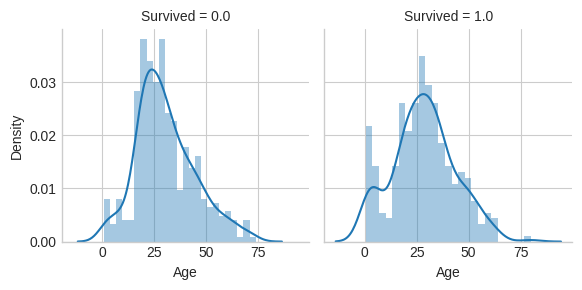

In [98]:
g = sns.FacetGrid(train_df, col = "Survived")
g.map(sns.distplot, "Age", bins = 25)
plt.show()

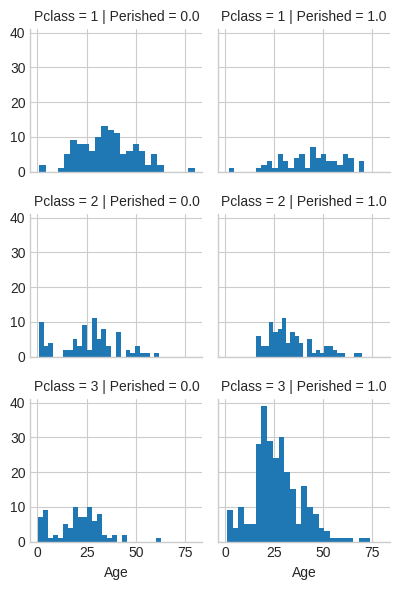

In [99]:
g = sns.FacetGrid(train_df, col = "Perished", row = "Pclass", height = 2)
g.map(plt.hist, "Age", bins = 25)
g.add_legend()
plt.show()

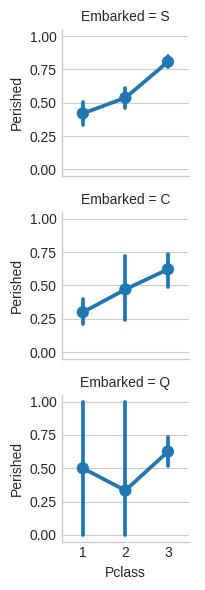

In [100]:
g = sns.FacetGrid(train_df, row = "Embarked", height = 2)
g.map(sns.pointplot, "Pclass","Perished")
g.add_legend()
plt.show()

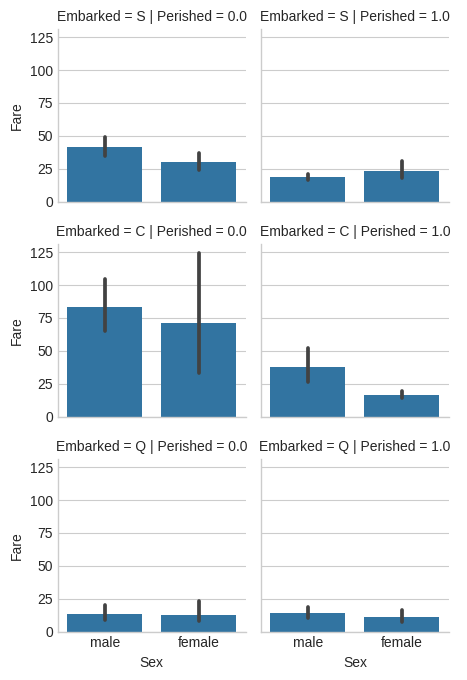

In [101]:
g = sns.FacetGrid(train_df, row = "Embarked", col = "Perished", height = 2.3)
g.map(sns.barplot, "Sex", "Fare")
g.add_legend()
plt.show()

In [102]:
train_df[train_df["Age"].isnull()]

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
5,6,1.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,0.0
17,18,0.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,1.0
19,20,0.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C,1.0
26,27,1.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,0.0
27,29,0.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,1300,NaN,3,"Riordan, Miss. Johanna Hannah""""",female,NaN,0,0,334915,7.7208,NaN,Q,NaN
1291,1302,NaN,3,"Naughton, Miss. Hannah",female,NaN,0,0,365237,7.7500,NaN,Q,NaN
1294,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN
1297,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN


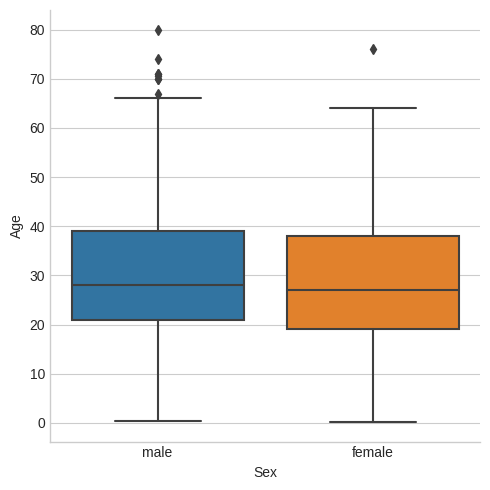

In [103]:
sns.catplot(x = "Sex", y = "Age", data = train_df, kind = "box")
plt.show()

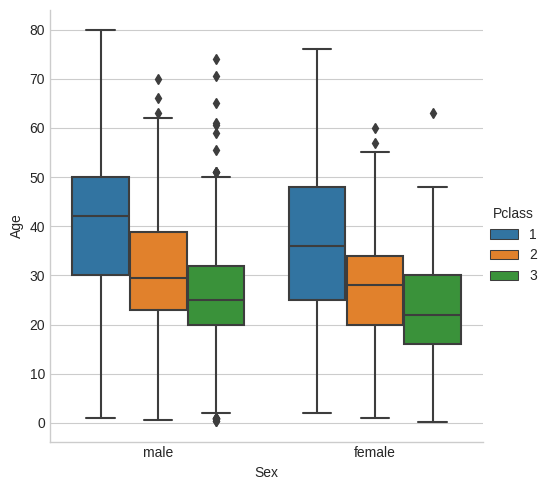

In [104]:
sns.catplot(x = "Sex", y = "Age", hue = "Pclass",data = train_df, kind = "box")
plt.show()

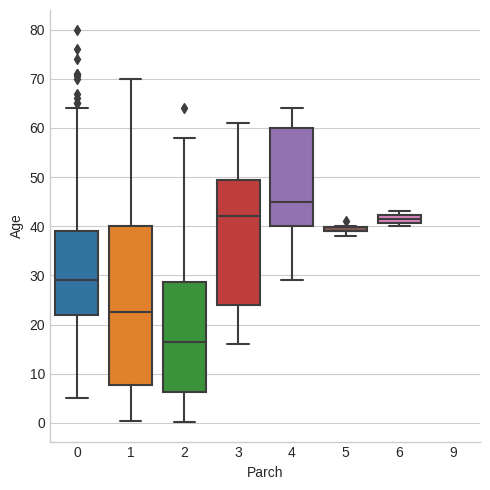

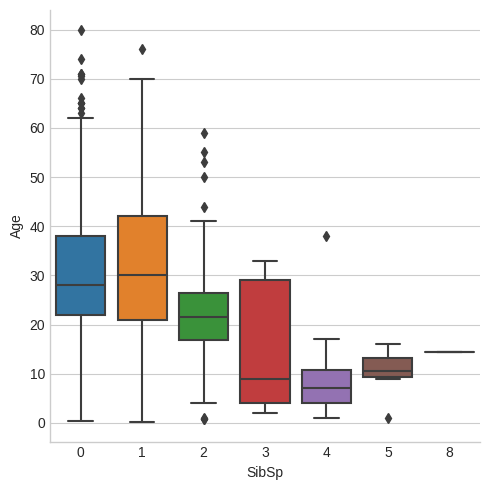

In [105]:
sns.catplot(x = "Parch", y = "Age", data = train_df, kind = "box")
sns.catplot(x = "SibSp", y = "Age", data = train_df, kind = "box")
plt.show()

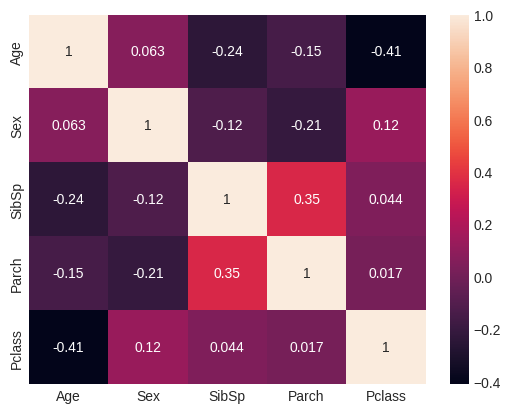

In [106]:
train_df["Sex"] = [1 if i == "male" else 0 for i in train_df["Sex"]]
sns.heatmap(train_df[["Age","Sex","SibSp","Parch","Pclass"]].corr(), annot = True)
plt.show()

In [107]:
index_nan_age = list(train_df["Age"][train_df["Age"].isnull()].index)
for i in index_nan_age:
    age_pred = train_df["Age"][((train_df["SibSp"] == train_df.iloc[i]["SibSp"]) &(train_df["Parch"] == train_df.iloc[i]["Parch"])& (train_df["Pclass"] == train_df.iloc[i]["Pclass"]))].median()
    age_med = train_df["Age"].median()
    if not np.isnan(age_pred):
        train_df["Age"].iloc[i] = age_pred
    else:
        train_df["Age"].iloc[i] = age_med
train_df[train_df["Age"].isnull()]

,PassengerId,Perished,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived


In [108]:
train_df["Name"].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [109]:
name = train_df["Name"]
train_df["Title"] = [i.split(".")[0].split(",")[-1].strip() for i in name]
train_df["Title"].head(10)

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
5        Mr
6        Mr
7    Master
8       Mrs
9       Mrs
Name: Title, dtype: object

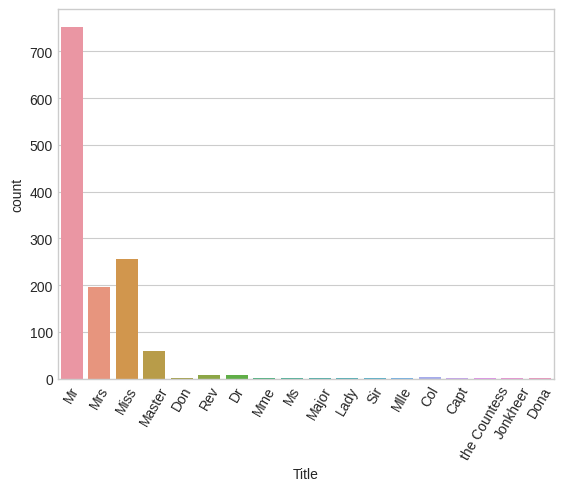

In [110]:
sns.countplot(x="Title", data = train_df)
plt.xticks(rotation = 60)
plt.show()

In [111]:
# convert to categorical
train_df["Title"] = train_df["Title"].replace(["Lady","the Countess","Capt","Col","Don","Dr","Major","Rev","Sir","Jonkheer","Dona"],"other")
train_df["Title"] = [0 if i == "Master" else 1 if i == "Miss" or i == "Ms" or i == "Mlle" or i == "Mrs" else 2 if i == "Mr" else 3 for i in train_df["Title"]]
train_df["Title"].head(20)

0     2
1     1
2     1
3     1
4     2
5     2
6     2
7     0
8     1
9     1
10    1
11    1
12    2
13    2
14    1
15    1
16    0
17    2
18    1
19    1
Name: Title, dtype: int64

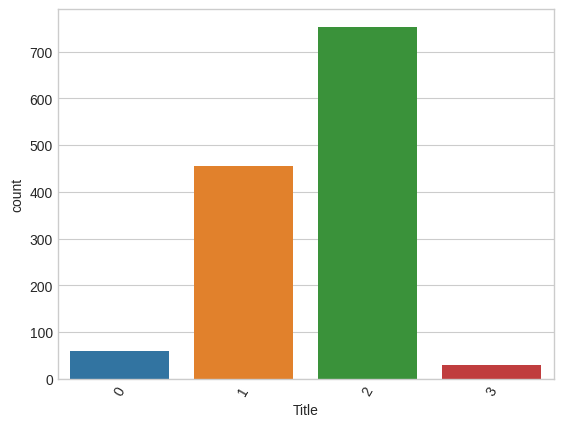

In [112]:
sns.countplot(x="Title", data = train_df)
plt.xticks(rotation = 60)
plt.show()

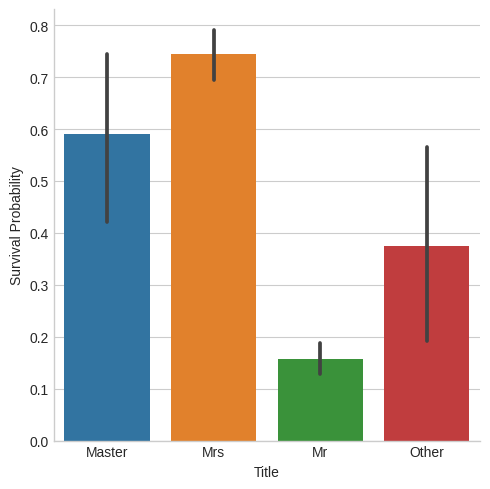

In [113]:
g = sns.catplot(x = "Title", y = "Survived", data = train_df, kind = "bar")
g.set_xticklabels(["Master","Mrs","Mr","Other"])
g.set_ylabels("Survival Probability")
plt.show()

In [114]:
train_df.drop(labels = ["Name"], axis = 1, inplace = True)
train_df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title
0,1,1.0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,2
1,2,0.0,1,0,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1
2,3,0.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,1
3,4,0.0,1,0,35.0,1,0,113803,53.1000,C123,S,1.0,1
4,5,1.0,3,1,35.0,0,0,373450,8.0500,NaN,S,0.0,2


In [115]:
train_df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title
0,1,1.0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,2
1,2,0.0,1,0,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1
2,3,0.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,1
3,4,0.0,1,0,35.0,1,0,113803,53.1000,C123,S,1.0,1
4,5,1.0,3,1,35.0,0,0,373450,8.0500,NaN,S,0.0,2


In [116]:
train_df["Fsize"] = train_df["SibSp"] + train_df["Parch"] + 1
train_df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title,Fsize
0,1,1.0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,2,2
1,2,0.0,1,0,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1,2
2,3,0.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,1,1
3,4,0.0,1,0,35.0,1,0,113803,53.1000,C123,S,1.0,1,2
4,5,1.0,3,1,35.0,0,0,373450,8.0500,NaN,S,0.0,2,1


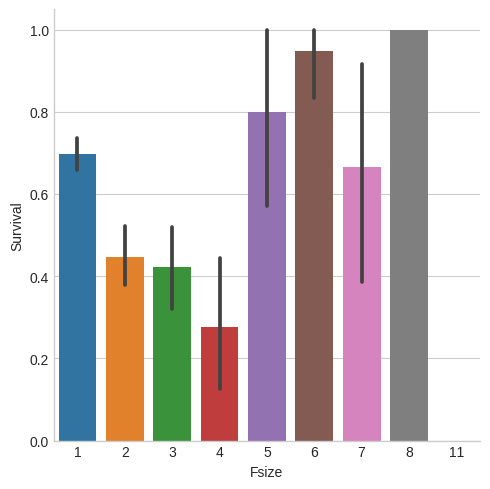

In [117]:
g = sns.catplot(x = "Fsize", y = "Perished", data = train_df, kind = "bar")
g.set_ylabels("Survival")
plt.show()

In [118]:
train_df["family_size"] = [1 if i < 5 else 0 for i in train_df["Fsize"]]
train_df.head(10)

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title,Fsize,family_size
0,1,1.0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,2,2,1
1,2,0.0,1,0,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1,2,1
2,3,0.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,1,1,1
3,4,0.0,1,0,35.0,1,0,113803,53.1000,C123,S,1.0,1,2,1
4,5,1.0,3,1,35.0,0,0,373450,8.0500,NaN,S,0.0,2,1,1
5,6,1.0,3,1,25.0,0,0,330877,8.4583,NaN,Q,0.0,2,1,1
6,7,1.0,1,1,54.0,0,0,17463,51.8625,E46,S,0.0,2,1,1
7,8,1.0,3,1,2.0,3,1,349909,21.0750,NaN,S,0.0,0,5,0
8,9,0.0,3,0,27.0,0,2,347742,11.1333,NaN,S,1.0,1,3,1
9,10,0.0,2,0,14.0,1,0,237736,30.0708,NaN,C,1.0,1,2,1


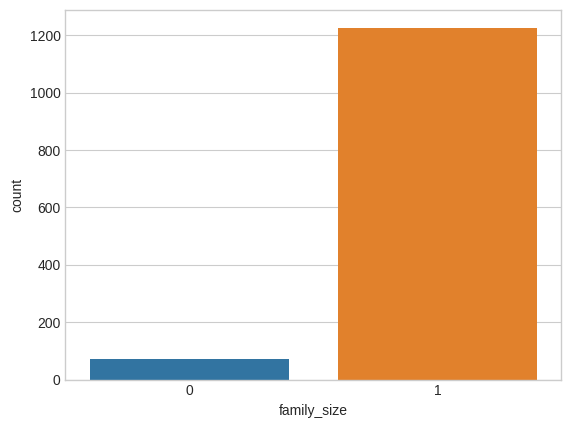

In [119]:
sns.countplot(x = "family_size", data = train_df)
plt.show()

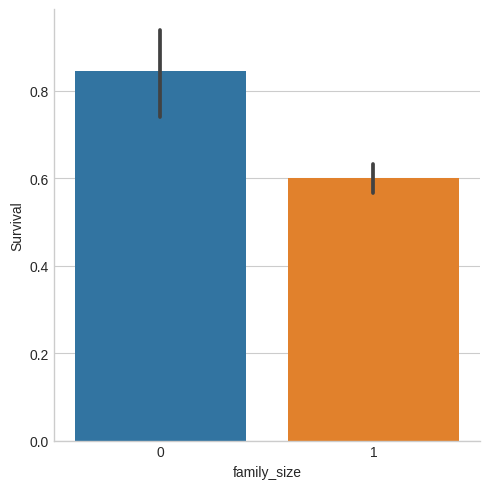

In [120]:
g = sns.catplot(x = "family_size", y = "Perished", data = train_df, kind = "bar")
g.set_ylabels("Survival")
plt.show()

In [121]:
train_df = pd.get_dummies(train_df, columns= ["family_size"])
train_df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Title,Fsize,family_size_0,family_size_1
0,1,1.0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,2,2,False,True
1,2,0.0,1,0,38.0,1,0,PC 17599,71.2833,C85,C,1.0,1,2,False,True
2,3,0.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0,1,1,False,True
3,4,0.0,1,0,35.0,1,0,113803,53.1000,C123,S,1.0,1,2,False,True
4,5,1.0,3,1,35.0,0,0,373450,8.0500,NaN,S,0.0,2,1,False,True


In [122]:
train_df["Embarked"].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

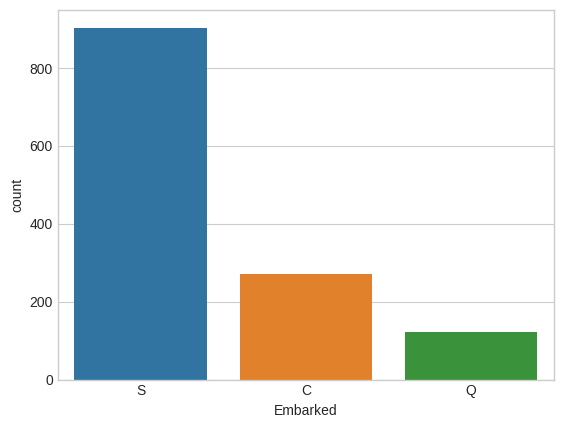

In [123]:
sns.countplot(x = "Embarked", data = train_df)
plt.show()


In [124]:
train_df = pd.get_dummies(train_df, columns=["Embarked"])
train_df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Survived,Title,Fsize,family_size_0,family_size_1,Embarked_C,Embarked_Q,Embarked_S
0,1,1.0,3,1,22.0,1,0,A/5 21171,7.2500,NaN,0.0,2,2,False,True,False,False,True
1,2,0.0,1,0,38.0,1,0,PC 17599,71.2833,C85,1.0,1,2,False,True,True,False,False
2,3,0.0,3,0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,1.0,1,1,False,True,False,False,True
3,4,0.0,1,0,35.0,1,0,113803,53.1000,C123,1.0,1,2,False,True,False,False,True
4,5,1.0,3,1,35.0,0,0,373450,8.0500,NaN,0.0,2,1,False,True,False,False,True


In [125]:
train_df["Ticket"].head(20)

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
Name: Ticket, dtype: object

In [126]:
a = "A/5. 2151"
a.replace(".","").replace("/","").strip().split(" ")[0]

'A5'

In [127]:
tickets = []
for i in list(train_df.Ticket):
    if not i.isdigit():
        tickets.append(i.replace(".","").replace("/","").strip().split(" ")[0])
    else:
        tickets.append("x")
train_df["Ticket"] = tickets
train_df["Ticket"].head(20)

0         A5
1         PC
2     STONO2
3          x
4          x
5          x
6          x
7          x
8          x
9          x
10        PP
11         x
12        A5
13         x
14         x
15         x
16         x
17         x
18         x
19         x
Name: Ticket, dtype: object

In [128]:
train_df.head()

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Survived,Title,Fsize,family_size_0,family_size_1,Embarked_C,Embarked_Q,Embarked_S
0,1,1.0,3,1,22.0,1,0,A5,7.2500,NaN,0.0,2,2,False,True,False,False,True
1,2,0.0,1,0,38.0,1,0,PC,71.2833,C85,1.0,1,2,False,True,True,False,False
2,3,0.0,3,0,26.0,0,0,STONO2,7.9250,NaN,1.0,1,1,False,True,False,False,True
3,4,0.0,1,0,35.0,1,0,x,53.1000,C123,1.0,1,2,False,True,False,False,True
4,5,1.0,3,1,35.0,0,0,x,8.0500,NaN,0.0,2,1,False,True,False,False,True


In [129]:
train_df = pd.get_dummies(train_df, columns= ["Ticket"], prefix = "T")
train_df.head(10)

,PassengerId,Perished,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Survived,...,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_x
0,1,1.0,3,1,22.0,1,0,7.2500,NaN,0.0,...,False,False,False,False,False,False,False,False,False,False
1,2,0.0,1,0,38.0,1,0,71.2833,C85,1.0,...,False,False,False,False,False,False,False,False,False,False
2,3,0.0,3,0,26.0,0,0,7.9250,NaN,1.0,...,False,False,False,False,True,False,False,False,False,False
3,4,0.0,1,0,35.0,1,0,53.1000,C123,1.0,...,False,False,False,False,False,False,False,False,False,True
4,5,1.0,3,1,35.0,0,0,8.0500,NaN,0.0,...,False,False,False,False,False,False,False,False,False,True
5,6,1.0,3,1,25.0,0,0,8.4583,NaN,0.0,...,False,False,False,False,False,False,False,False,False,True
6,7,1.0,1,1,54.0,0,0,51.8625,E46,0.0,...,False,False,False,False,False,False,False,False,False,True
7,8,1.0,3,1,2.0,3,1,21.0750,NaN,0.0,...,False,False,False,False,False,False,False,False,False,True
8,9,0.0,3,0,27.0,0,2,11.1333,NaN,1.0,...,False,False,False,False,False,False,False,False,False,True
9,10,0.0,2,0,14.0,1,0,30.0708,NaN,1.0,...,False,False,False,False,False,False,False,False,False,True


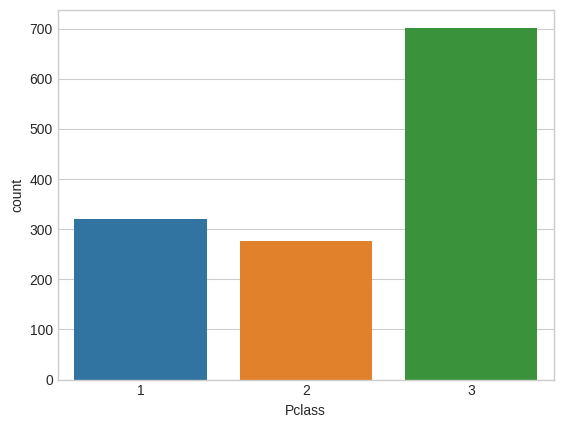

In [130]:
sns.countplot(x = "Pclass", data = train_df)
plt.show()

In [131]:
train_df["Sex"] = train_df["Sex"].astype("category")
train_df = pd.get_dummies(train_df, columns=["Sex"])
train_df.head()

,PassengerId,Perished,Pclass,Age,SibSp,Parch,Fare,Cabin,Survived,Title,...,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_x,Sex_0,Sex_1
0,1,1.0,3,22.0,1,0,7.2500,NaN,0.0,2,...,False,False,False,False,False,False,False,False,False,True
1,2,0.0,1,38.0,1,0,71.2833,C85,1.0,1,...,False,False,False,False,False,False,False,False,True,False
2,3,0.0,3,26.0,0,0,7.9250,NaN,1.0,1,...,False,False,True,False,False,False,False,False,True,False
3,4,0.0,1,35.0,1,0,53.1000,C123,1.0,1,...,False,False,False,False,False,False,False,True,True,False
4,5,1.0,3,35.0,0,0,8.0500,NaN,0.0,2,...,False,False,False,False,False,False,False,True,False,True


In [132]:
# Sex_0 → Sex_female, Sex_1 → Sex_male にrename
train_df.rename(columns={"Sex_0": "Sex_female", "Sex_1": "Sex_male"}, inplace=True)
train_df.head()

,PassengerId,Perished,Pclass,Age,SibSp,Parch,Fare,Cabin,Survived,Title,...,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_x,Sex_female,Sex_male
0,1,1.0,3,22.0,1,0,7.2500,NaN,0.0,2,...,False,False,False,False,False,False,False,False,False,True
1,2,0.0,1,38.0,1,0,71.2833,C85,1.0,1,...,False,False,False,False,False,False,False,False,True,False
2,3,0.0,3,26.0,0,0,7.9250,NaN,1.0,1,...,False,False,True,False,False,False,False,False,True,False
3,4,0.0,1,35.0,1,0,53.1000,C123,1.0,1,...,False,False,False,False,False,False,False,True,True,False
4,5,1.0,3,35.0,0,0,8.0500,NaN,0.0,2,...,False,False,False,False,False,False,False,True,False,True


In [133]:
# Titleを One-Hot エンコーディング
train_df = pd.get_dummies(train_df, columns=["Title"])
train_df.head()

,PassengerId,Perished,Pclass,Age,SibSp,Parch,Fare,Cabin,Survived,Fsize,...,T_SWPP,T_WC,T_WEP,T_x,Sex_female,Sex_male,Title_0,Title_1,Title_2,Title_3
0,1,1.0,3,22.0,1,0,7.2500,NaN,0.0,2,...,False,False,False,False,False,True,False,False,True,False
1,2,0.0,1,38.0,1,0,71.2833,C85,1.0,2,...,False,False,False,False,True,False,False,True,False,False
2,3,0.0,3,26.0,0,0,7.9250,NaN,1.0,1,...,False,False,False,False,True,False,False,True,False,False
3,4,0.0,1,35.0,1,0,53.1000,C123,1.0,2,...,False,False,False,True,True,False,False,True,False,False
4,5,1.0,3,35.0,0,0,8.0500,NaN,0.0,1,...,False,False,False,True,False,True,False,False,True,False


In [134]:
train_df.drop(labels = ["PassengerId", "Cabin"], axis = 1, inplace = True)
train_df.columns

Index(['Perished', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived',
       'Fsize', 'family_size_0', 'family_size_1', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'T_A', 'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS', 'T_C',
       'T_CA', 'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP', 'T_PC',
       'T_PP', 'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW',
       'T_SCPARIS', 'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2',
       'T_SOTONOQ', 'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP',
       'T_WC', 'T_WEP', 'T_x', 'Sex_female', 'Sex_male', 'Title_0', 'Title_1',
       'Title_2', 'Title_3'],
      dtype='object')

In [135]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [136]:
train_df_len

881

In [137]:
test = train_df[train_df_len:]
test.drop(labels = ["Survived", "Perished"], axis = 1, inplace = True)
test.head()

,Pclass,Age,SibSp,Parch,Fare,Fsize,family_size_0,family_size_1,Embarked_C,Embarked_Q,...,T_SWPP,T_WC,T_WEP,T_x,Sex_female,Sex_male,Title_0,Title_1,Title_2,Title_3
881,3,34.5,0,0,7.8292,1,False,True,False,True,...,False,False,False,True,False,True,False,False,True,False
882,3,47.0,1,0,7.0000,2,False,True,False,False,...,False,False,False,True,True,False,False,True,False,False
883,2,62.0,0,0,9.6875,1,False,True,False,True,...,False,False,False,True,False,True,False,False,True,False
884,3,27.0,0,0,8.6625,1,False,True,False,False,...,False,False,False,True,False,True,False,False,True,False
885,3,22.0,1,1,12.2875,3,False,True,False,False,...,False,False,False,True,True,False,False,True,False,False


In [138]:
train = train_df[:train_df_len]
X_train = train.drop(labels = ["Survived", "Perished"], axis = 1)  # 両方削除
y_train = train["Perished"]  # Perishedを予測ターゲットに
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.33, random_state = 42)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))
print("test",len(test))

X_train 590
X_test 291
y_train 590
y_test 291
test 418


In [139]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log_train = round(logreg.score(X_train, y_train)*100,2) 
acc_log_test = round(logreg.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 83.22
Testing Accuracy: % 81.1


In [140]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"]}

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}
classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
0.8355932203389831
Fitting 10 folds for each of 28 candidates, totalling 280 fits
0.7983050847457627
Fitting 10 folds for each of 54 candidates, totalling 540 fits
0.840677966101695
Fitting 10 folds for each of 14 candidates, totalling 140 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.8186440677966103
Fitting 10 folds for each of 40 candidates, totalling 400 fits
0.7762711864406779


In [141]:
# cv_result と cv_std が定義されているか確認
if 'cv_result' not in locals() or 'cv_std' not in locals():
    print("Error: cv_result or cv_std not found. Please run the GridSearchCV cell first.")
else:
    cv_results = pd.DataFrame({
        "Cross Validation Means": cv_result,
        "Cross Validation Std": cv_std,
        "ML Models": model_names
    })

    plt.figure(figsize=(10, 8))
    g = sns.barplot(x="Cross Validation Means", y="ML Models", data=cv_results)
    g.set_xlabel("Mean Accuracy")
    g.set_title("Cross Validation Scores")
    plt.tight_layout()
    plt.show()

    print(cv_results.sort_values(by="Cross Validation Means", ascending=False).to_string(index=False))

Error: cv_result or cv_std not found. Please run the GridSearchCV cell first.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

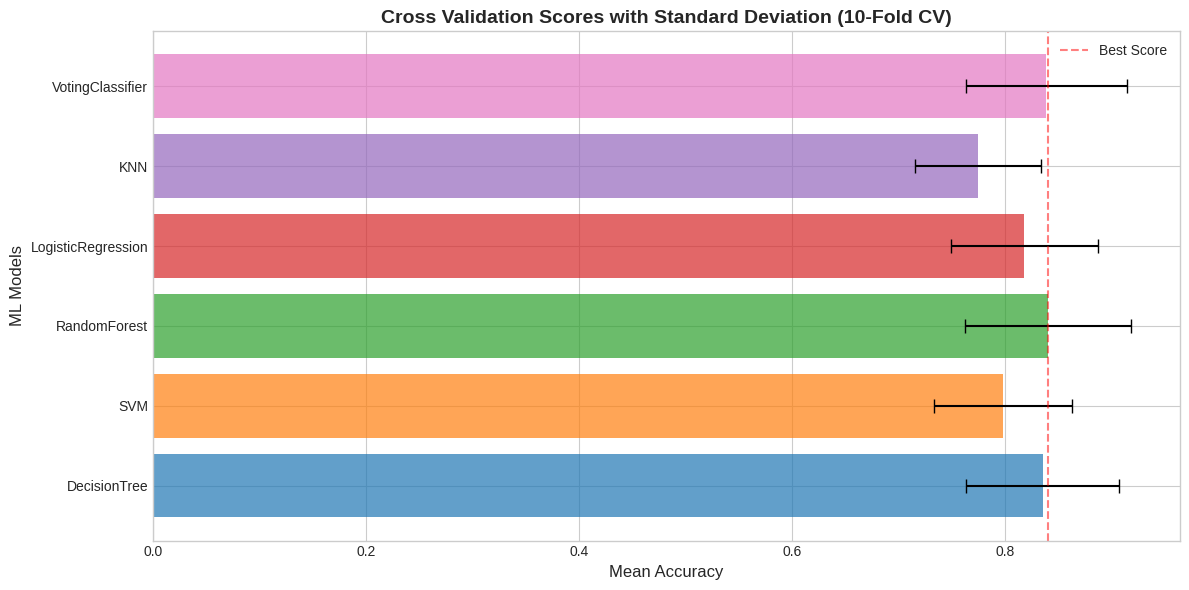

         ML Models  CV Mean   CV Std
      RandomForest 0.840678 0.078113
  VotingClassifier 0.838983 0.075514
      DecisionTree 0.835593 0.071529
LogisticRegression 0.818644 0.069492
               SVM 0.798305 0.064518
               KNN 0.774576 0.059225


In [142]:
from sklearn.model_selection import cross_val_score

# Cross-validation scores with standard deviation for each model
cv_means = []
cv_stds = []
model_names = ['DecisionTree', 'SVM', 'RandomForest', 'LogisticRegression', 'KNN']

for i in range(len(best_estimators)):
    cv_scores = cross_val_score(best_estimators[i], X_train, y_train, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
    cv_means.append(cv_scores.mean())
    cv_stds.append(cv_scores.std())

# VotingClassifier のスコア計算
votingC = VotingClassifier(estimators = [("dt",best_estimators[0]),
                                        ("rfc",best_estimators[2]),
                                        ("lr",best_estimators[3])],
                                        voting = "soft", n_jobs = -1)

# VotingClassifier の交差検証スコア
voting_cv_scores = cross_val_score(votingC, X_train, y_train, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
voting_mean = voting_cv_scores.mean()
voting_std = voting_cv_scores.std()

# Fit して test set での精度も表示
votingC.fit(X_train, y_train)
voting_test_acc = accuracy_score(votingC.predict(X_test), y_test)

# すべてのモデルを含むDataFrame作成
cv_means.append(voting_mean)
cv_stds.append(voting_std)
model_names.append('VotingClassifier')

cv_results_detailed = pd.DataFrame({
    "ML Models": ["DecisionTree", "SVM", "RandomForest", "LogisticRegression", "KNN", "VotingClassifier"],
    "CV Mean": cv_means,
    "CV Std": cv_stds
})

# Visualization with error bars
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#e377c2']
bars = plt.barh(cv_results_detailed["ML Models"], cv_results_detailed["CV Mean"], 
                xerr=cv_results_detailed["CV Std"], capsize=5, color=colors, alpha=0.7)
plt.xlabel("Mean Accuracy", fontsize=12)
plt.ylabel("ML Models", fontsize=12)
plt.title("Cross Validation Scores with Standard Deviation (10-Fold CV)", fontsize=14, fontweight='bold')
plt.axvline(x=cv_results_detailed["CV Mean"].max(), color='red', linestyle='--', alpha=0.5, label='Best Score')
plt.legend()
plt.tight_layout()
plt.show()

print(cv_results_detailed.sort_values(by="CV Mean", ascending=False).to_string(index=False))

DecisionTree: Mean = 0.8356, Std = 0.0715
SVM: Mean = 0.7983, Std = 0.0645
RandomForest: Mean = 0.8407, Std = 0.0781
LogisticRegression: Mean = 0.8186, Std = 0.0695
KNN: Mean = 0.7746, Std = 0.0592


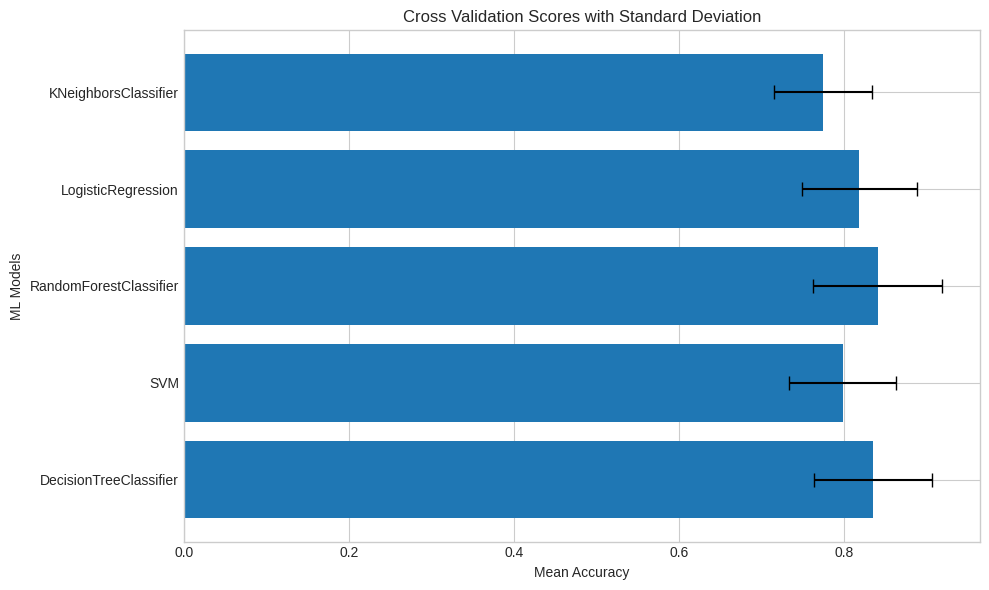


                ML Models   CV Mean    CV Std
0  DecisionTreeClassifier  0.835593  0.071529
1                     SVM  0.798305  0.064518
2  RandomForestClassifier  0.840678  0.078113
3      LogisticRegression  0.818644  0.069492
4    KNeighborsClassifier  0.774576  0.059225


In [143]:
from sklearn.model_selection import cross_val_score

# Cross-validation scores with standard deviation for each model

cv_means = []
cv_stds = []

for i in range(len(best_estimators)):
    cv_scores = cross_val_score(best_estimators[i], X_train, y_train, cv=StratifiedKFold(n_splits=10), scoring='accuracy')
    cv_means.append(cv_scores.mean())
    cv_stds.append(cv_scores.std())
    print(f"{['DecisionTree', 'SVM', 'RandomForest', 'LogisticRegression', 'KNN'][i]}: Mean = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# Create a more detailed results dataframe
cv_results_detailed = pd.DataFrame({
    "ML Models": ["DecisionTreeClassifier", "SVM", "RandomForestClassifier", "LogisticRegression", "KNeighborsClassifier"],
    "CV Mean": cv_means,
    "CV Std": cv_stds
})

# Visualization with error bars
plt.figure(figsize=(10, 6))
plt.barh(cv_results_detailed["ML Models"], cv_results_detailed["CV Mean"], xerr=cv_results_detailed["CV Std"], capsize=5)
plt.xlabel("Mean Accuracy")
plt.ylabel("ML Models")
plt.title("Cross Validation Scores with Standard Deviation")
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print(cv_results_detailed)

In [144]:
# 提出用の予測を作成
# VotingClassifier で予測（最も精度が高いと思われるモデル）
test_predictions = votingC.predict(test)

# 提出用DataFrameを作成
# PassengerIdはtest_dfから取得（train_df_len以降）
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Perished': test_predictions.astype(int)
})

# outputフォルダが存在しない場合は作成
import os
output_dir = '../output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# CSVファイルを保存
submission.to_csv(f'{output_dir}/detai.csv', index=False)

print("Submission file created successfully!")
print(f"File saved to: {output_dir}/detai.csv")
print(f"\nFirst few rows of submission:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")
print(f"Perished distribution:\n{submission['Perished'].value_counts()}")

Submission file created successfully!
File saved to: ../output/detai.csv

First few rows of submission:
   PassengerId  Perished
0          892         1
1          893         0
2          894         1
3          895         1
4          896         0
5          897         1
6          898         0
7          899         1
8          900         0
9          901         1

Submission shape: (418, 2)
Perished distribution:
Perished
1    250
0    168
Name: count, dtype: int64


In [145]:
X_train.isnull().sum()

Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
Fsize            0
family_size_0    0
family_size_1    0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
T_A              0
T_A4             0
T_A5             0
T_AQ3            0
T_AQ4            0
T_AS             0
T_C              0
T_CA             0
T_CASOTON        0
T_FC             0
T_FCC            0
T_Fa             0
T_LINE           0
T_LP             0
T_PC             0
T_PP             0
T_PPP            0
T_SC             0
T_SCA3           0
T_SCA4           0
T_SCAH           0
T_SCOW           0
T_SCPARIS        0
T_SCParis        0
T_SOC            0
T_SOP            0
T_SOPP           0
T_SOTONO2        0
T_SOTONOQ        0
T_SP             0
T_STONO          0
T_STONO2         0
T_STONOQ         0
T_SWPP           0
T_WC             0
T_WEP            0
T_x              0
Sex_female       0
Sex_male         0
Title_0          0
Title_1          0
Title_2     